In [ ]:
from google.colab import files


uploaded = files.upload()
#here I import the animelist2clean.csv

Saving animelist2clean.csv to animelist2clean.csv


In [ ]:
import pandas as pd
import io
import json
import networkx as nx
import matplotlib.pyplot as plt
#here I import the relevant libraries

In [ ]:
anime_data = pd.read_csv(io.BytesIO(uploaded['animelist2clean.csv']))
print(anime_data)
#here I read the dataset into a Pandas DataFrame

      anime_id                                              title  \
0        11013                                      Inu x Boku SS   
1         2104                                   Seto no Hanayome   
2         5262                                 Shugo Chara!! Doki   
3          721                                      Princess Tutu   
4        12365                                Bakuman. 3rd Season   
...        ...                                                ...   
6663     37405                            Dokidoki Little Ooyasan   
6664     37886                        Wo Shi Jiang Xiaobai (2018)   
6665     37255              Genki Genki Non-tan: Obake Mura Meiro   
6666     35229                                Mr. Men Little Miss   
6667     36315  Mushi Mushi Mura no Nakama-tachi: Minna Ii Tok...   

                  title_english                      title_japanese  \
0     Inu X Boku Secret Service                              妖狐×僕SS   
1         My Bride is a Merma

In [ ]:
#here I define a function to turn the JSON-like strings from the related column into a Python dictionary
def parse_related_column(related_str):
    try:
        return json.loads(related_str.replace("'", '"'))
    except json.JSONDecodeError:
        return {}

anime_data['related_parsed'] = anime_data['related'].apply(parse_related_column)

print(anime_data[['anime_id', 'title', 'related_parsed']].head(10))

   anime_id                          title  \
0     11013                  Inu x Boku SS   
1      2104               Seto no Hanayome   
2      5262             Shugo Chara!! Doki   
3       721                  Princess Tutu   
4     12365            Bakuman. 3rd Season   
5      6586            Yume-iro Pâtissière   
6       178                   Ultra Maniac   
7      2787  Shakugan no Shana II (Second)   
8      4477    Nodame Cantabile: Paris-hen   
9       853         Ouran Koukou Host Club   

                                      related_parsed  
0  {'Adaptation': [{'mal_id': 17207, 'type': 'man...  
1  {'Adaptation': [{'mal_id': 759, 'type': 'manga...  
2  {'Adaptation': [{'mal_id': 101, 'type': 'manga...  
3  {'Adaptation': [{'mal_id': 1581, 'type': 'mang...  
4  {'Adaptation': [{'mal_id': 9711, 'type': 'mang...  
5  {'Adaptation': [{'mal_id': 10386, 'type': 'man...  
6  {'Adaptation': [{'mal_id': 956, 'type': 'manga...  
7  {'Adaptation': [{'mal_id': 3074, 'type': 'mang... 

In [ ]:
#here I try to extract edges, but first I check the datatype for unexpected lists
edges = []
for index, row in anime_data.iterrows():
    anime_id = row['anime_id']
    related_dict = row['related_parsed']
    if isinstance(related_dict, dict):
        for relation_type, related_list in related_dict.items():
            for related_anime in related_list:
                edges.append((anime_id, related_anime['mal_id'], relation_type))
    elif isinstance(related_dict, list):
        print(f"Unexpected list in row {index}: {related_dict}")

#they are many unexcepted lists in the related column, which is why the code needs to be able to handle both lists and dicitonaries

Unexpected list in row 57: []
Unexpected list in row 63: []
Unexpected list in row 65: []
Unexpected list in row 71: []
Unexpected list in row 73: []
Unexpected list in row 86: []
Unexpected list in row 93: []
Unexpected list in row 99: []
Unexpected list in row 110: []
Unexpected list in row 111: []
Unexpected list in row 129: []
Unexpected list in row 139: []
Unexpected list in row 146: []
Unexpected list in row 149: []
Unexpected list in row 156: []
Unexpected list in row 157: []
Unexpected list in row 159: []
Unexpected list in row 174: []
Unexpected list in row 180: []
Unexpected list in row 186: []
Unexpected list in row 189: []
Unexpected list in row 216: []
Unexpected list in row 235: []
Unexpected list in row 243: []
Unexpected list in row 262: []
Unexpected list in row 269: []
Unexpected list in row 291: []
Unexpected list in row 296: []
Unexpected list in row 297: []
Unexpected list in row 318: []
Unexpected list in row 329: []
Unexpected list in row 332: []
Unexpected list 

In [ ]:
#here I modify the parsing function to handle both lists and dictionaries
def parse_related_column(related_str):
    try:
        parsed = json.loads(related_str.replace("'", '"'))
        if isinstance(parsed, list):
            return {'related': parsed}
        elif isinstance(parsed, dict):
            return parsed
        else:
            return {}
    except json.JSONDecodeError:
        return {}

#then I apply the modified parser to the 'related' column
anime_data['related_parsed'] = anime_data['related'].apply(parse_related_column)

print(anime_data[['anime_id', 'title', 'related_parsed']].head(10))

   anime_id                          title  \
0     11013                  Inu x Boku SS   
1      2104               Seto no Hanayome   
2      5262             Shugo Chara!! Doki   
3       721                  Princess Tutu   
4     12365            Bakuman. 3rd Season   
5      6586            Yume-iro Pâtissière   
6       178                   Ultra Maniac   
7      2787  Shakugan no Shana II (Second)   
8      4477    Nodame Cantabile: Paris-hen   
9       853         Ouran Koukou Host Club   

                                      related_parsed  
0  {'Adaptation': [{'mal_id': 17207, 'type': 'man...  
1  {'Adaptation': [{'mal_id': 759, 'type': 'manga...  
2  {'Adaptation': [{'mal_id': 101, 'type': 'manga...  
3  {'Adaptation': [{'mal_id': 1581, 'type': 'mang...  
4  {'Adaptation': [{'mal_id': 9711, 'type': 'mang...  
5  {'Adaptation': [{'mal_id': 10386, 'type': 'man...  
6  {'Adaptation': [{'mal_id': 956, 'type': 'manga...  
7  {'Adaptation': [{'mal_id': 3074, 'type': 'mang... 

In [ ]:
#here I create a list of edges based on the 'related_parsed' column
edges = []
for index, row in anime_data.iterrows():
    anime_id = row['anime_id']
    related_dict = row['related_parsed']

    if isinstance(related_dict, dict):
        for relation_type, related_list in related_dict.items():
            for related_anime in related_list:
                edges.append((anime_id, related_anime['mal_id'], relation_type))
    elif isinstance(related_dict, list):
        for related_anime in related_dict['related']:
            edges.append((anime_id, related_anime['mal_id'], 'related'))

print(edges[:10])

[(11013, 17207, 'Adaptation'), (11013, 13403, 'Sequel'), (2104, 759, 'Adaptation'), (2104, 4163, 'Sequel'), (2104, 5199, 'Side story'), (2104, 28385, 'Alternative version'), (5262, 101, 'Adaptation'), (5262, 2923, 'Prequel'), (5262, 7082, 'Sequel'), (721, 1581, 'Adaptation')]


In [ ]:
#here I try to create a NetworkX graph from the edges, but this gives me the error "dictionary update sequence element #0 has length 1; 2 is required"
G = nx.Graph()
G.add_edges_from(edges)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [ ]:
#here I check if all edges are correctly formatted
edges_cleaned = []
for edge in edges:
    if len(edge) == 3:
        edges_cleaned.append(edge)
    else:
        print(f"Skipping malformed edge: {edge}")

#and I look at the first 50 edges
print(edges_cleaned[:50])

[(11013, 17207, 'Adaptation'), (11013, 13403, 'Sequel'), (2104, 759, 'Adaptation'), (2104, 4163, 'Sequel'), (2104, 5199, 'Side story'), (2104, 28385, 'Alternative version'), (5262, 101, 'Adaptation'), (5262, 2923, 'Prequel'), (5262, 7082, 'Sequel'), (721, 1581, 'Adaptation'), (721, 3265, 'Summary'), (12365, 9711, 'Adaptation'), (12365, 10030, 'Prequel'), (12365, 15711, 'Prequel'), (12365, 23361, 'Other'), (6586, 10386, 'Adaptation'), (6586, 8894, 'Side story'), (6586, 9441, 'Sequel'), (178, 956, 'Adaptation'), (178, 179, 'Alternative version'), (2787, 3074, 'Adaptation'), (2787, 355, 'Prequel'), (2787, 3956, 'Spin-off'), (2787, 14957, 'Spin-off'), (2787, 6572, 'Sequel'), (4477, 419, 'Adaptation'), (4477, 1698, 'Prequel'), (4477, 5656, 'Other'), (4477, 6187, 'Side story'), (4477, 8038, 'Sequel'), (853, 30, 'Adaptation'), (4814, 765, 'Adaptation'), (4814, 3092, 'Prequel'), (4814, 25649, 'Sequel'), (7054, 2921, 'Adaptation'), (7054, 9366, 'Side story'), (7054, 10298, 'Side story'), (11123

In [ ]:
#here I check all edges (instead of only 50)
for edge in edges_cleaned:
    if not isinstance(edge, tuple) or len(edge) != 3:
        print(f"Malformed edge found: {edge}")
#result: there are no non-tuple or malformed entries

In [ ]:
#here I try to create a NetworkX graph from the edges again, but still get the same error ("dictionary update sequence element #0 has length 1; 2 is required")
G = nx.Graph()
G.add_edges_from(edges_cleaned)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [ ]:
#here I create a NetworkX graph that handles the third element of each edge as a dictionary key-value pair
G = nx.Graph()
G.add_edges_from((u, v, {'relation': r}) for u, v, r in edges_cleaned)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

print("Sample edges with attributes:")
for edge in list(G.edges(data=True))[:10]:
    print(edge)

Number of nodes: 9647
Number of edges: 9793
Sample edges with attributes:
(11013, 17207, {'relation': 'Adaptation'})
(11013, 13403, {'relation': 'Prequel'})
(2104, 759, {'relation': 'Adaptation'})
(2104, 4163, {'relation': 'Prequel'})
(2104, 5199, {'relation': 'Parent story'})
(2104, 28385, {'relation': 'Alternative version'})
(2104, 3675, {'relation': 'Adaptation'})
(759, 4163, {'relation': 'Adaptation'})
(4163, 7041, {'relation': 'Spin-off'})
(5262, 101, {'relation': 'Adaptation'})


In [ ]:
#here I calculate the graph density and average degree
print(f"Graph density: {nx.density(G)}")

avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Average degree: {avg_degree:.2f}")

Graph density: 0.00021047776044441348
Average degree: 2.03


In [ ]:
#here I measure degree centrality
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by degree centrality:")
for node, centrality in top_degree:
    print(f"Anime ID {node}: {centrality:.4f}")

Top 10 nodes by degree centrality:
Anime ID 1960: 0.0064
Anime ID 235: 0.0063
Anime ID 2471: 0.0058
Anime ID 21: 0.0053
Anime ID 80: 0.0047
Anime ID 966: 0.0036
Anime ID 813: 0.0036
Anime ID 527: 0.0029
Anime ID 1929: 0.0027
Anime ID 603: 0.0026


In [ ]:
#here I try to measure betweenness centrality, but this results in long processing time
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:")
for node, centrality in top_betweenness:
    print(f"Anime ID {node}: {centrality:.4f}")

KeyboardInterrupt: 

In [ ]:
#here, to avoid the long runtime, I use an approximation of betweenness centrality
from networkx.algorithms.centrality import betweenness_centrality_subset

nodes_subset = list(G.nodes())[:500]
betweenness_centrality = betweenness_centrality_subset(G, sources=nodes_subset, targets=nodes_subset, normalized=True)

top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by approximate betweenness centrality:")
for node, centrality in top_betweenness:
    print(f"Anime ID {node}: {centrality:.4f}")


Top 10 nodes by approximate betweenness centrality:
Anime ID 813: 0.0002
Anime ID 21: 0.0002
Anime ID 80: 0.0002
Anime ID 966: 0.0001
Anime ID 8687: 0.0001
Anime ID 210: 0.0001
Anime ID 35686: 0.0001
Anime ID 2471: 0.0001
Anime ID 87: 0.0001
Anime ID 895: 0.0001


In [ ]:
#here I explore how many connected components are in the network
connected_components = list(nx.connected_components(G))
print(f"Number of connected components: {len(connected_components)}")

largest_component = max(connected_components, key=len)
print(f"Largest component size: {len(largest_component)}")

Number of connected components: 1831
Largest component size: 1959


In [ ]:
#here I detect communities
import networkx.algorithms.community as nx_comm

communities = nx_comm.louvain_communities(G, seed=42)

print(f"Number of detected communities: {len(communities)}")
print(f"First 3 communities: {list(communities)[:3]}")

Number of detected communities: 1853
First 3 communities: [{13403, 11013, 17207}, {7041, 28385, 4163, 759, 2104, 3675, 5199}, {2784, 721, 3265, 10759, 1581}]


Connections for Anime ID 1960:
Adaptations: 0
Sequels: 0
Other Relationships: 62
Total Connections: 62


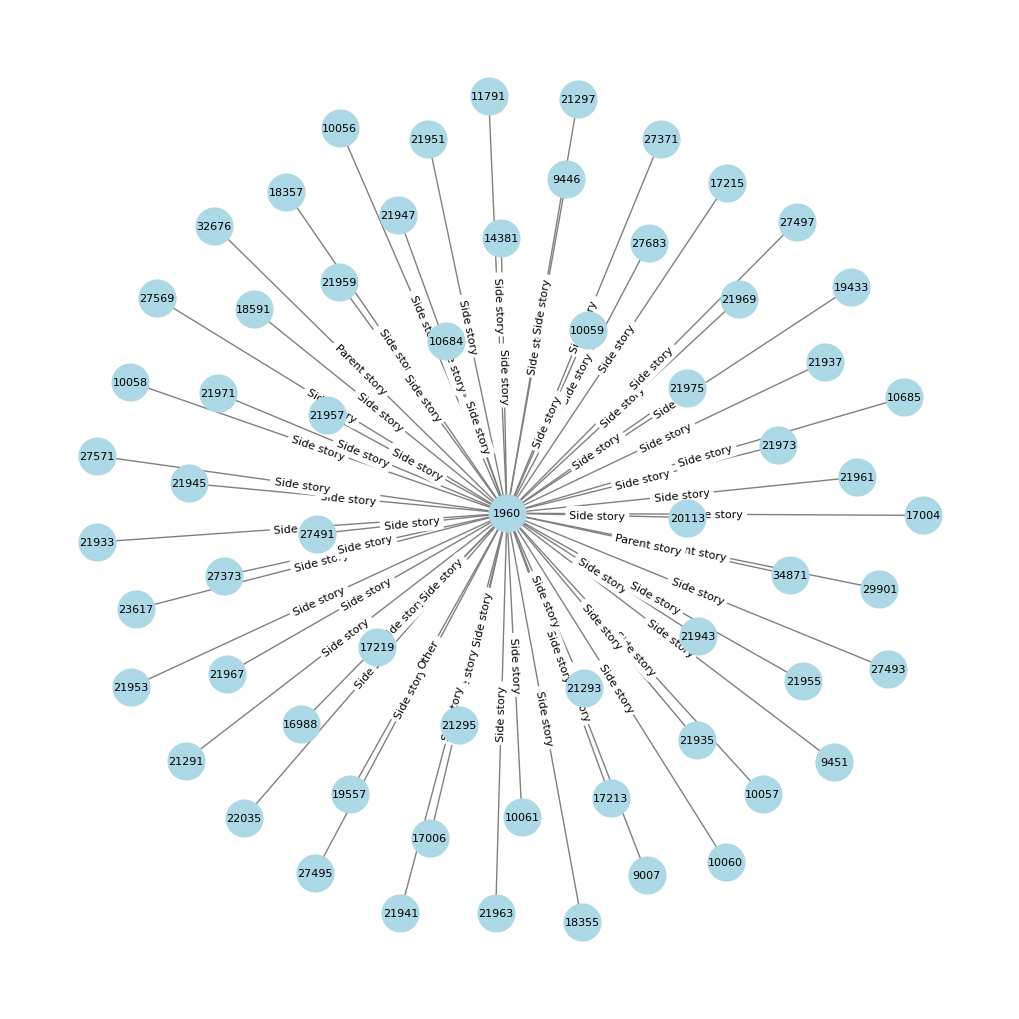

In [ ]:
#here I create an ego network for Anime ID 1960
anime_id = 1960

connected_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u == anime_id or v == anime_id]

relationship_counts = {"Adaptation": 0, "Sequel": 0, "Other": 0}
for _, _, data in connected_edges:
    relation_type = data.get("relation", "Other")
    if relation_type in relationship_counts:
        relationship_counts[relation_type] += 1
    else:
        relationship_counts["Other"] += 1

print(f"Connections for Anime ID {anime_id}:")
print(f"Adaptations: {relationship_counts['Adaptation']}")
print(f"Sequels: {relationship_counts['Sequel']}")
print(f"Other Relationships: {relationship_counts['Other']}")
print(f"Total Connections: {len(connected_edges)}")

ego_graph = nx.ego_graph(G, anime_id)
pos = nx.spring_layout(ego_graph, seed=42)

plt.figure(figsize=(10, 10))
nx.draw(ego_graph, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=8, edge_color='gray')
edge_labels = nx.get_edge_attributes(ego_graph, 'relation')
nx.draw_networkx_edge_labels(ego_graph, pos, edge_labels=edge_labels, font_size=8)
plt.show()

In [ ]:
#here I extract and count all relationship types for Anime ID 1960
relationship_types = {}

for u, v, data in G.edges(data=True):
    if u == 1960 or v == 1960:
        relation_type = data.get("relation", "Unknown")
        if relation_type in relationship_types:
            relationship_types[relation_type] += 1
        else:
            relationship_types[relation_type] = 1

print(f"All relationship types for Anime ID 1960: {relationship_types}")


All relationship types for Anime ID 1960: {'Side story': 58, 'Parent story': 3, 'Other': 1}


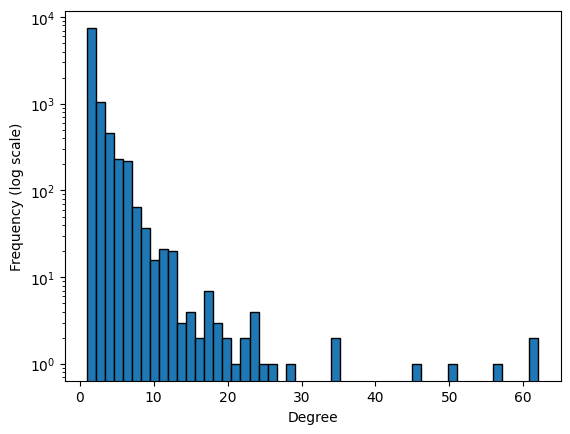

In [ ]:
#here I visualize the degree distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, edgecolor='black', log=True)
plt.xlabel('Degree')
plt.ylabel('Frequency (log scale)')
plt.show()

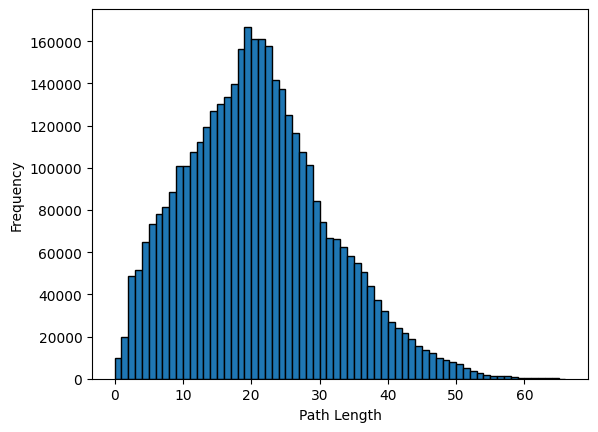

In [ ]:
#here I visualize the shortest path lengths
path_lengths = dict(nx.shortest_path_length(G))
length_counts = [dist for node_paths in path_lengths.values() for dist in node_paths.values()]
plt.hist(length_counts, bins=range(max(length_counts)), edgecolor='black')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

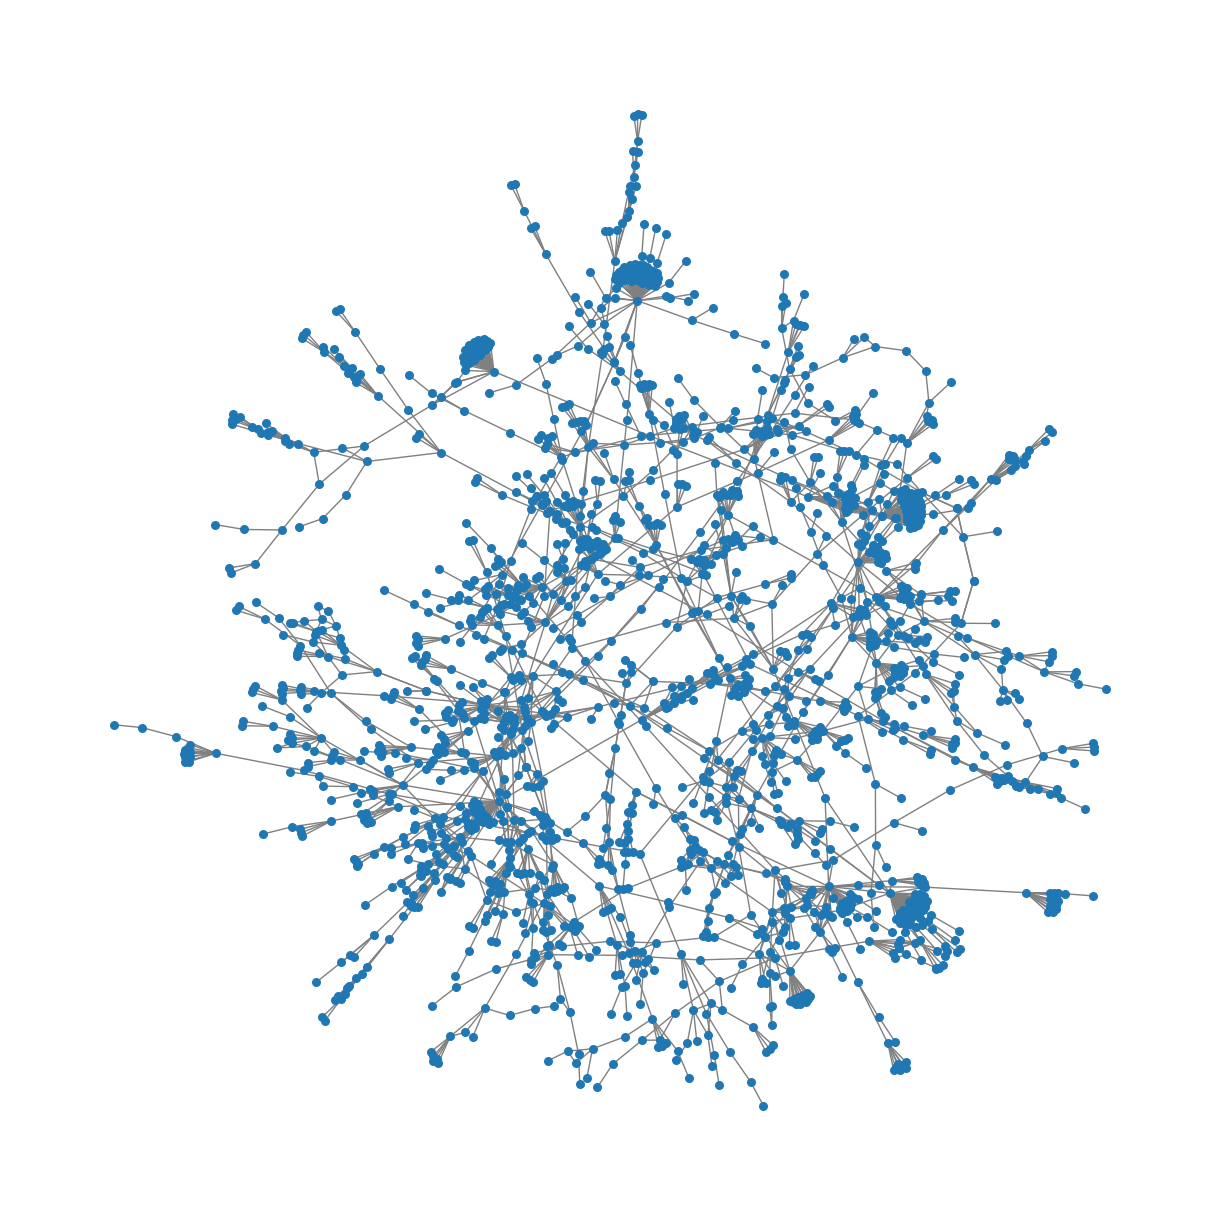

In [ ]:
#here I visualize the largest connected component
connected_components = list(nx.connected_components(G))

largest_component = max(connected_components, key=len)

largest_subgraph = G.subgraph(largest_component)

plt.figure(figsize=(12, 12))
nx.draw(largest_subgraph, with_labels=False, node_size=30, edge_color="gray")
plt.show()

In [ ]:
#here I identify the largest three communities
sorted_communities = sorted(communities, key=len, reverse=True)
top_3_communities = sorted_communities[:3]

print("Sizes of the three largest communities:")
for i, community in enumerate(top_3_communities):
    print(f"Community {i + 1}: {len(community)} nodes")

Sizes of the three largest communities:
Community 1: 207 nodes
Community 2: 143 nodes
Community 3: 117 nodes


In [ ]:
#here I analyze the genres of the three largest communities
genre_dict = anime_data.set_index('anime_id')['genre'].to_dict()

for i, community in enumerate(top_3_communities):
    community_genres = [genre_dict.get(node, "Unknown") for node in community]
    genre_counts = pd.Series(community_genres).value_counts()

    print(f"\nCommunity {i + 1} genre distribution:")
    print(genre_counts)


Community 1 genre distribution:
Unknown                                                                      83
Action, Military, Sci-Fi, Space, Drama, Mecha                                 9
Fantasy, Sci-Fi, Shounen, Slice of Life                                       5
Action, Sci-Fi, Mecha                                                         5
Military, Sci-Fi, Space, Drama, Mecha                                         5
                                                                             ..
Drama, Romance, Slice of Life                                                 1
Action, Mystery, Supernatural, Drama, Romance, Fantasy, Josei, Shounen Ai     1
Action, Comedy, Police, Romance, Sci-Fi                                       1
Action, Military, Sci-Fi, Space, Mecha, Shounen                               1
Comedy, Supernatural, Romance, Fantasy, Josei, Shounen Ai                     1
Name: count, Length: 84, dtype: int64

Community 2 genre distribution:
Unknown         

In [ ]:
#here I analyze the top 5 genres in the three largest communities excluding the value "Unknown"
for i, community in enumerate(top_3_communities):
    community_genres = [genre_dict.get(node, "Unknown") for node in community]
    genre_counts = pd.Series(community_genres).value_counts()
    genre_counts = genre_counts[genre_counts.index != "Unknown"].head(5)
    print(f"\nTop 5 Genres in Community {i + 1} (excluding 'Unknown'):")
    print(genre_counts)


Top 5 Genres in Community 1 (excluding 'Unknown'):
Action, Military, Sci-Fi, Space, Drama, Mecha    9
Fantasy, Sci-Fi, Shounen, Slice of Life          5
Action, Sci-Fi, Mecha                            5
Military, Sci-Fi, Space, Drama, Mecha            5
Comedy, Sports, Drama, School, Shounen           4
Name: count, dtype: int64

Top 5 Genres in Community 2 (excluding 'Unknown'):
Adventure, Comedy, Fantasy, Kids            16
Action, Adventure, Comedy, Fantasy, Kids     9
Action, Adventure, Comedy, Kids, Fantasy     6
Adventure, Fantasy, Kids                     6
Comedy                                       5
Name: count, dtype: int64

Top 5 Genres in Community 3 (excluding 'Unknown'):
Comedy, Parody, School                         7
Action, Adventure, Comedy, Drama               6
Adventure, Comedy, Drama, Fantasy, Shounen     3
Action, Adventure, Comedy, Fantasy, Shounen    3
Adventure, Comedy, Mecha                       2
Name: count, dtype: int64


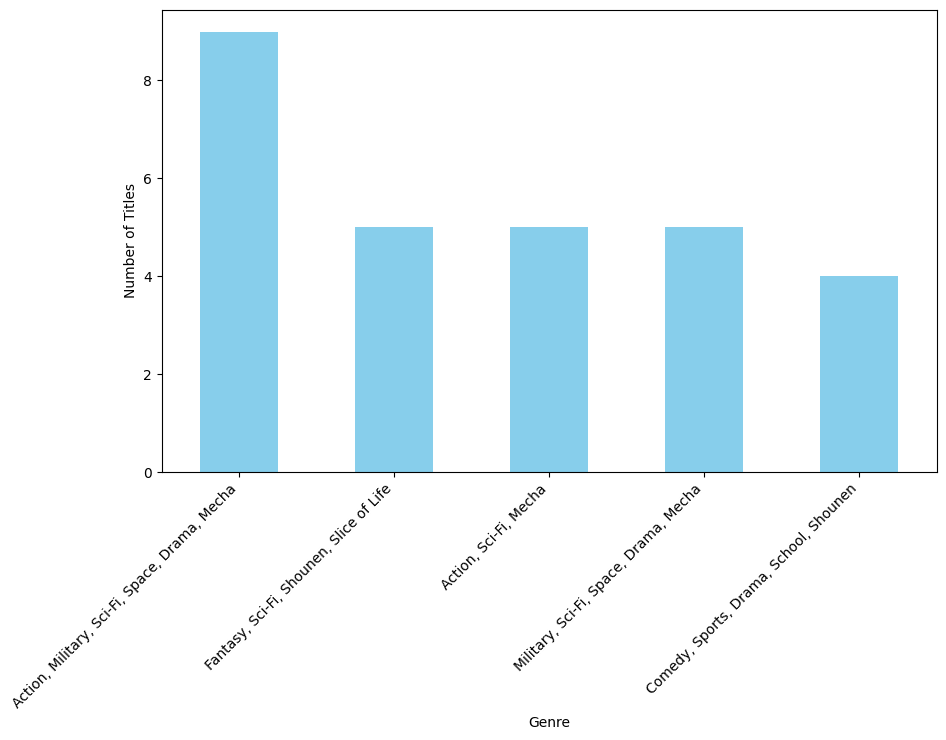

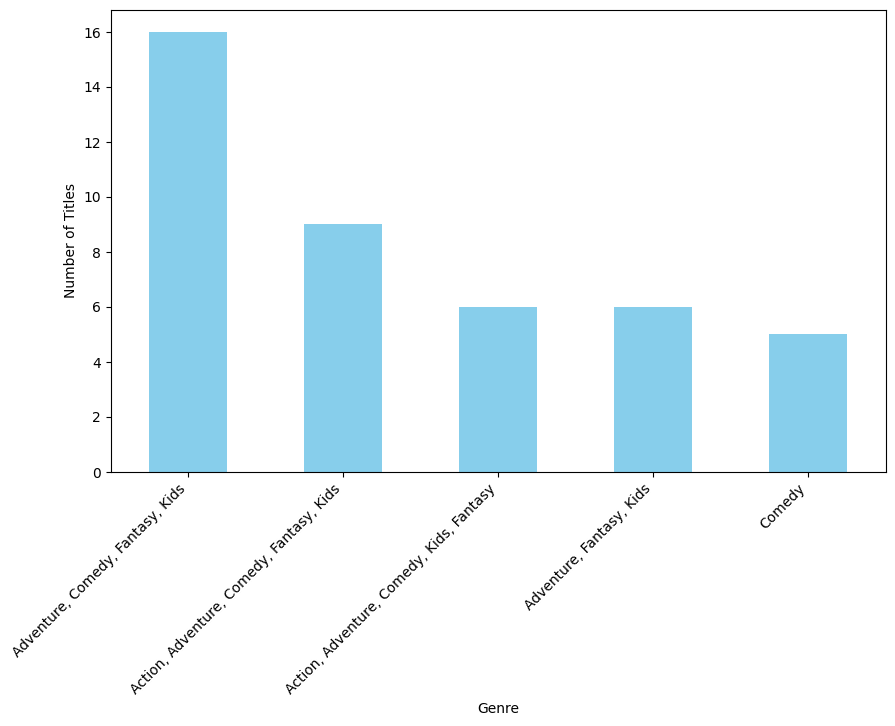

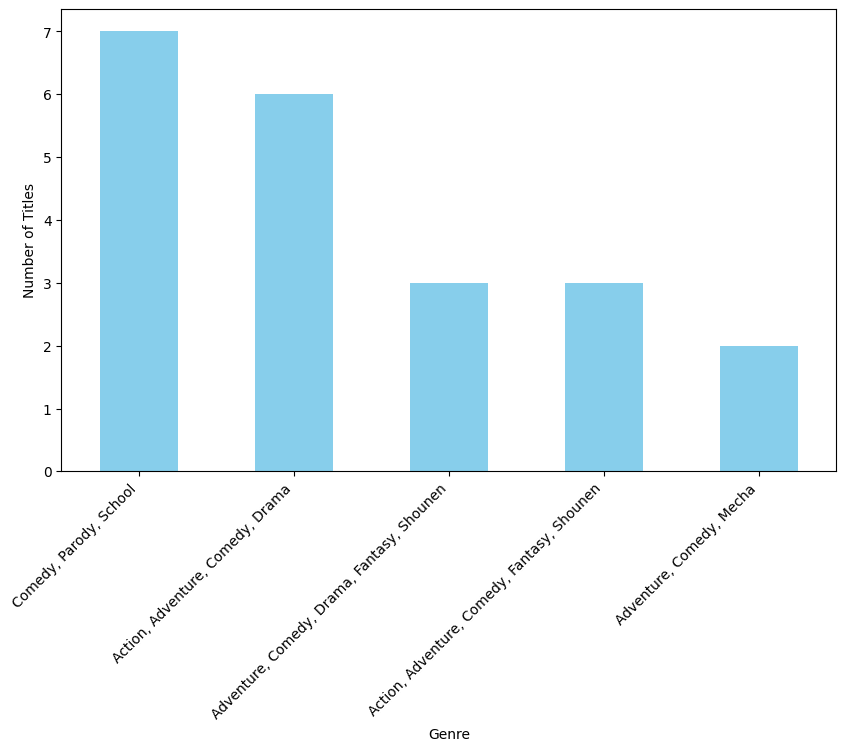

In [ ]:
#here I visualize the top 5 genres for each of the largest communities
for i, community in enumerate(top_3_communities):
    community_genres = [genre_dict.get(node, "Unknown") for node in community]
    genre_counts = pd.Series(community_genres).value_counts()
    genre_counts = genre_counts[genre_counts.index != "Unknown"].head(5)
    plt.figure(figsize=(10, 6))
    genre_counts.plot(kind="bar", color="skyblue")
    plt.xlabel("Genre")
    plt.ylabel("Number of Titles")
    plt.xticks(rotation=45, ha="right")
    plt.show()